In [100]:
#%% Import
import sys
sys.path.append("/home/jan/Documents/ETH/Masterarbeit/climada_python")
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import geopandas as gpd
from climada.hazard import Hazard
from scipy import sparse
import copy as cp
from matplotlib import pyplot as plt
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import h5py
import hail_functions as fct
from sklearn.metrics import mean_squared_error
from scipy import optimize
import time
from scipy import stats
from scipy.stats import spearmanr


In [101]:
#%% Parameter
# If any value in force_new_hdf5_generation is True the script will ask for 
# user input wether to overwrite the hdf5 with the new data
force_new_hdf5_generation ={"haz_real": False, 
                            "haz_synth": False, 
                            "haz_dur": False,
                            "exp_infr": False, 
                            "exp_agr": False}
name_hdf5_file={"haz_real": "haz_real.hdf5", 
                "haz_synth": "haz_synth.hdf5", 
                "haz_dur": "haz_dur.hdf5",
                "exp_infr": "exp_switzerland.hdf5", 
                "exp_agr": "exp_agr.hdf5"}

# Optimization
optimize_type = "" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
plot_img = False
haz_type = "HL"
ev_list = ["12/07/2011", "13/07/2011"]#["01/07/2019", "02/07/2019", "18/08/2019", "06/08/2019", "30/06/2019", "15/06/2019"]#, "01/07/2019", "18/06/2019"]
start_day = 0 #min = 0
end_day = 183 #max = 183
# imp_fun_infrastructure = {"imp_id": 1, "L": 0.1, "x_0": 100, "k": 10}
# imp_fun_grape = {"imp_id": 2, "L": 0.8, "x_0": 35, "k": 10}
# imp_fun_fruit = {"imp_id": 3, "L": 1.0, "x_0": 80, "k": 10}
# imp_fun_agriculture = {"imp_id": 4, "L": 0.5, "x_0": 50, "k": 10}
# imp_fun_dur_grape = {"imp_id": 5, "L": 0.8, "x_0": 50, "k": 1}
# imp_fun_dur_fruit = {"imp_id": 6, "L": 1.0, "x_0": 50, "k": 1}
# imp_fun_dur_agriculture = {"imp_id": 7, "L": 0.5, "x_0": 50, "k": 1}
imp_fun_infrastructure = {"imp_id": 1, "L": 0.08, "x_0": 100, "k": 5}
imp_fun_grape = {"imp_id": 2, "L": 0.39, "x_0": 47, "k": 40}
imp_fun_fruit = {"imp_id": 3, "L": 0.88, "x_0": 67, "k": 18}
imp_fun_agriculture = {"imp_id": 4, "L": 0.89, "x_0": 199, "k": 32}
imp_fun_dur_grape = {"imp_id": 5, "L": 0.73, "x_0": 11, "k": 38}
imp_fun_dur_fruit = {"imp_id": 6, "L": 0.29, "x_0": 120, "k": 0}
imp_fun_dur_agriculture = {"imp_id": 7, "L": 0.94, "x_0": 128, "k": 31}

imp_fun_parameter = [imp_fun_infrastructure,
                     imp_fun_grape,
                     imp_fun_fruit,
                     imp_fun_agriculture,
                     imp_fun_dur_grape, 
                     imp_fun_dur_fruit, 
                     imp_fun_dur_agriculture]
# Path to Data 
input_folder = "/home/jan/Documents/ETH/Masterarbeit/input"
results_folder = "~/Documents/ETH/Masterarbeit/results"
years =["2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]
years_synth = ["1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001" ,"2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]


In [102]:
#%% Hazard
haz_real = fct.load_haz(force_new_hdf5_generation, "haz_real", name_hdf5_file, input_folder, years)
haz_synth = fct.load_haz(force_new_hdf5_generation, "haz_synth", name_hdf5_file, input_folder, years_synth)
haz_dur = fct.load_haz(force_new_hdf5_generation, "haz_dur", name_hdf5_file, input_folder, years)

haz_real.check()
haz_synth.check()

if plot_img:
    haz_real.plot_intensity(event = 0)
    haz_real.plot_fraction(event = 0)

2021-03-11 14:34:49,137 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_real.hdf5
2021-03-11 14:34:49,366 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_synth.hdf5
2021-03-11 14:34:49,518 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_dur.hdf5


2021-03-11 14:34:53,963 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:53,967 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:53,971 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:53,974 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:53,977 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e35a7cf50>,
      dtype=object)

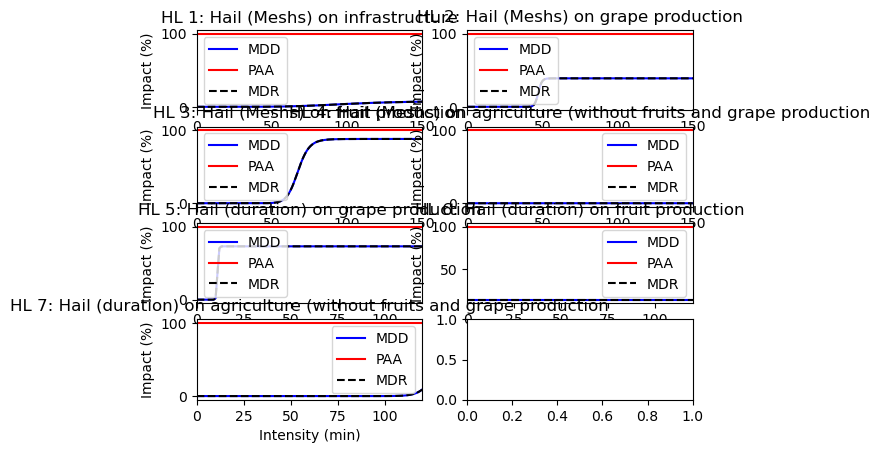

In [103]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
for imp_fun_dict in imp_fun_parameter:
    imp_fun = fct.create_impact_func(haz_type, 
                                 imp_fun_dict["imp_id"], 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    ifset_hail.append(imp_fun)
ifset_hail.plot()

2021-03-11 14:34:58,467 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:58,470 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:58,472 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:58,475 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 14:34:58,477 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e35a7c050>,
      dtype=object)

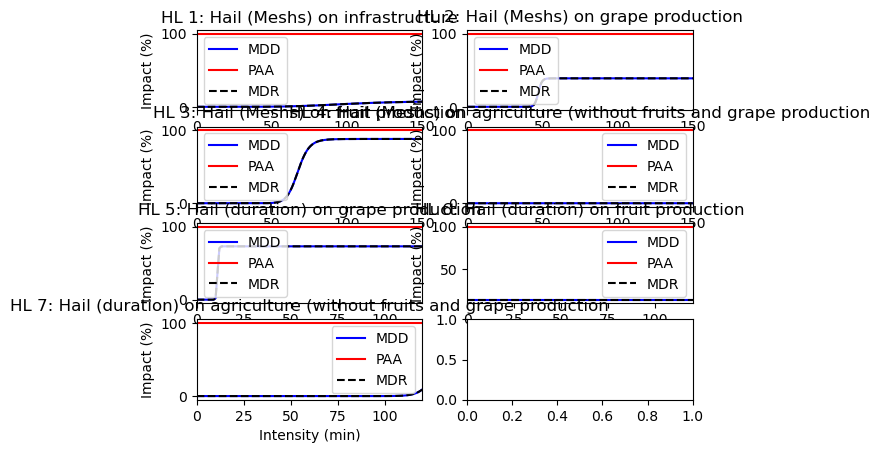

In [104]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
for imp_fun_dict in imp_fun_parameter:
    imp_fun = fct.create_impact_func(haz_type, 
                                 imp_fun_dict["imp_id"], 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    ifset_hail.append(imp_fun)
ifset_hail.plot()

In [105]:
#%% Exposure

exp_infr = fct.load_exp_infr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_agr = fct.load_exp_agr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_dur = exp_agr.copy()
exp_dur["if_HL"] = exp_dur["if_HL"]+3 #change if_HL to match the corresponding imp_id
if plot_img:    
    exp_infr.plot_basemap()
    #This takes to long. Do over night!!!
    #exp_agr.plot_basemap() 


2021-03-11 14:35:03,099 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_switzerland.hdf5
2021-03-11 14:35:03,787 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-11 14:35:03,789 - climada.entity.exposures.base - INFO - cover not set.
2021-03-11 14:35:03,790 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-11 14:35:03,900 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_agr.hdf5
2021-03-11 14:35:03,993 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-11 14:35:03,995 - climada.entity.exposures.base - INFO - cover not set.
2021-03-11 14:35:03,995 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-11 14:35:04,000 - climada.entity.exposures.base - INFO - geometry not set.


2021-03-11 14:35:52,791 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 14:35:52,795 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


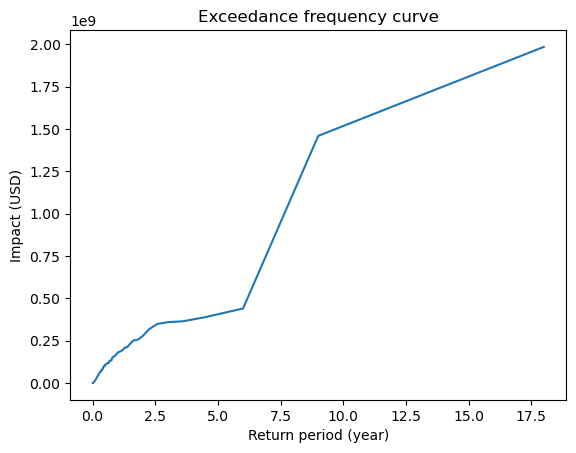

2021-03-11 14:35:53,439 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 14:35:53,446 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


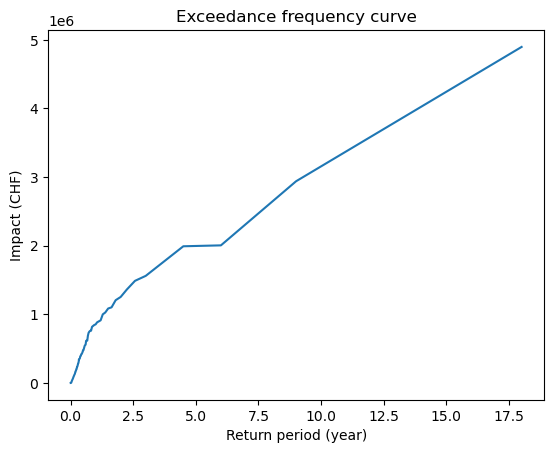

2021-03-11 14:35:57,587 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 14:35:57,596 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


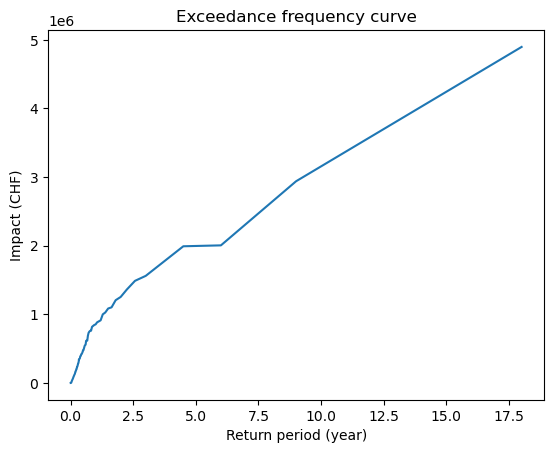

In [106]:
#%% Impact

imp_infr = Impact()
imp_infr.calc(exp_infr, ifset_hail, haz_real,save_mat=True)
# imp_infr.plot_raster_eai_exposure()
freq_curve_infr = imp_infr.calc_freq_curve()
freq_curve_infr.plot()
plt.show()

imp_agr = Impact()
imp_agr.calc(exp_agr, ifset_hail, haz_real, save_mat = True)
freq_curve_agr = imp_agr.calc_freq_curve()
freq_curve_agr.plot()
plt.show()

imp_agr_dur = Impact()
imp_agr_dur.calc(exp_dur, ifset_hail, haz_dur, save_mat = True)
freq_curve_agr = imp_agr.calc_freq_curve()
freq_curve_agr.plot()
plt.show()

return_period = cp.copy(freq_curve_infr.return_per)


dmg infr 1014.320324045909 Mio CHF, dmg agr_meshs 4.249118697566551 Mio CHF, dmg agr_dur 59.42210565680223 Mio CHF


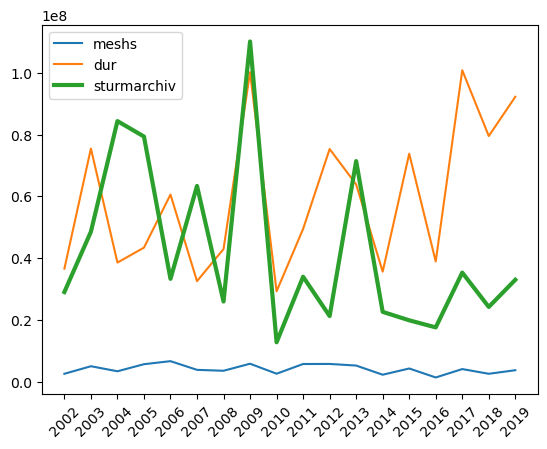

pearson for agr with meshs (score, p_value) = (0.4421997166837591, 0.06614113384110695) 
pearson for agr with dur (score, p_value) = (0.16464121779523178, 0.5138563120710609) 
spearman for agr with meshs (score, p_value) = (0.479876160990712, 0.04386464036882083)
spearman for agr with dur (score, p_value) = (0.23839009287925697, 0.340779724454077)


In [107]:
#just some stuff
print("dmg infr {} Mio CHF, dmg agr_meshs {} Mio CHF, dmg agr_dur {} Mio CHF".format(imp_infr.aai_agg/1e6, imp_agr.aai_agg/1e6, imp_agr_dur.aai_agg/1e6))
agr_meshs_yearly_imp = list(imp_agr.calc_impact_year_set(year_range = [2002, 2019]).values())
agr_dur_yearly_imp = list(imp_agr_dur.calc_impact_year_set(year_range = [2002, 2019]).values())
# plt.figure()
# plt.bar(years, agr_dur_yearly_imp)
# plt.show()
# plt.figure()
# plt.bar(years, agr_meshs_yearly_imp)
dmg_from_sturmarchiv = [29.12, 48.61, 84.34, 79.35, 33.37, 63.40, 26.05, 110.06, 12.87, 34.05, 21.35, 71.41, 22.71, 19.98, 17.69, 35.39, 24.30, 33.07]
dmg_from_sturmarchiv_complet = [23.1, 24.1, 13.8, 11.7, 18.4, 43.4, 30.1, 29.0, 36.7, 20.2, 56.8, 43.3, 28.2, 37.1, 66.2, 28.8, 57.5, 38.7, 43.8, 68.7, 66.4, 69.9, 116, 34.1, 40.3, 40.6, 35.0, 107, 84.5, 24.7 ,  29.12, 48.61, 84.34, 79.35, 33.37, 63.40, 26.05, 110.06, 12.87, 34.05, 21.35, 71.41, 22.71, 19.98, 17.69, 35.39, 24.30, 33.07]
dmg_from_sturmarchiv = [int(i*1e6) for i in dmg_from_sturmarchiv]
dmg_from_sturmarchiv_complet = [int(i*1e6) for i in dmg_from_sturmarchiv_complet]

dmg_from_vkg = [164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50, 16.55]
dmg_from_vkg = [i*1e6 for i in dmg_from_vkg]
norm_agr_meshs_yearly_imp = np.divide(agr_meshs_yearly_imp, min(agr_meshs_yearly_imp))
norm_agr_dur_yearly_imp = np.divide(agr_dur_yearly_imp, min(agr_dur_yearly_imp))
norm_dmg_from_sturmarchiv = np.divide(dmg_from_sturmarchiv, min(dmg_from_sturmarchiv)) #[i / min(dmg_from_sturmarchiv) for i in dmg_from_sturmarchiv]

#plot
plt.figure()
plt.plot(years, agr_meshs_yearly_imp)
plt.plot(agr_dur_yearly_imp)
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend(["meshs", "dur", "sturmarchiv"])
plt.xticks(rotation = 45)
plt.show()

print("pearson for agr with meshs (score, p_value) = {} ".format(stats.pearsonr(norm_dmg_from_sturmarchiv, norm_agr_meshs_yearly_imp)))
print("pearson for agr with dur (score, p_value) = {} ".format(stats.pearsonr(norm_dmg_from_sturmarchiv, norm_agr_dur_yearly_imp)))

coef, p_value = spearmanr(norm_dmg_from_sturmarchiv, norm_agr_meshs_yearly_imp)    
print("spearman for agr with meshs (score, p_value) = ({}, {})".format(coef, p_value))
coef, p_value = spearmanr(norm_dmg_from_sturmarchiv, norm_agr_dur_yearly_imp)    
print("spearman for agr with dur (score, p_value) = ({}, {})".format(coef, p_value))

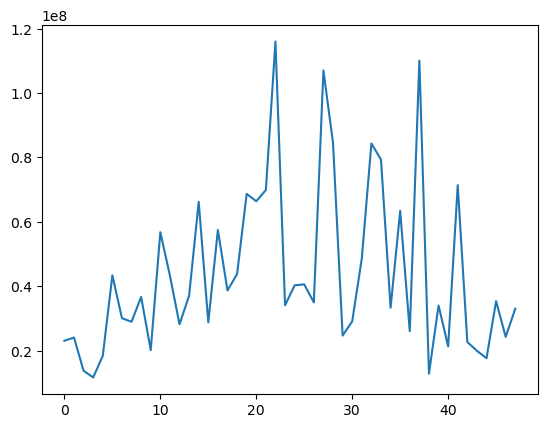

In [56]:
plt.plot(dmg_from_sturmarchiv_complet)

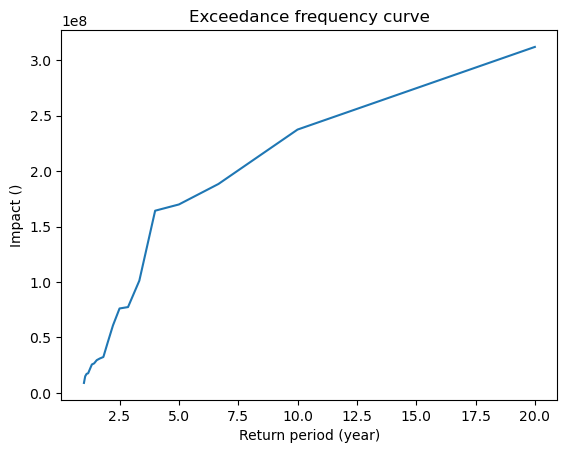

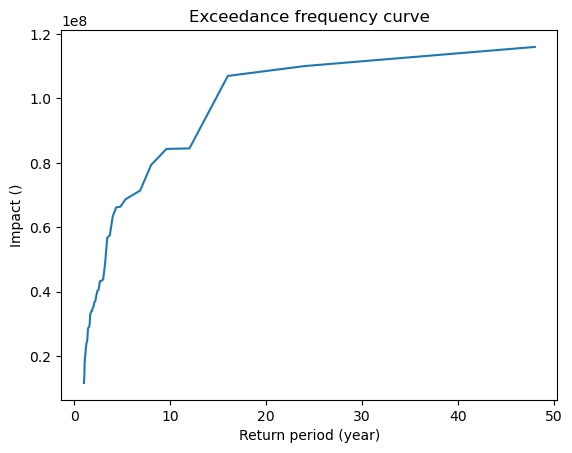

In [141]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
vkg_data = [45.36, 77.37, 21.39, 164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50]
vkg_data = [int(i*1e6) for i in vkg_data] 
imp_vkg = Impact()
imp_vkg.at_event = np.asarray(vkg_data)
imp_vkg.frequency = np.ones(len(imp_vkg.at_event))/len(imp_vkg.at_event)
imp_vkg_freq_curve_org = imp_vkg.calc_freq_curve()
imp_vkg_freq_curve_org.plot()

imp_sturm_complet = Impact()
imp_sturm_complet.at_event = np.asarray(dmg_from_sturmarchiv_complet)
imp_sturm_complet.frequency = np.ones(len(imp_sturm_complet.at_event))/len(imp_sturm_complet.at_event)
imp_sturm_complet_freq_curve_org = imp_sturm_complet.calc_freq_curve()
imp_sturm_complet_freq_curve_org.plot()
return_period_org = cp.copy(imp_vkg_freq_curve.return_per)


return_per = return_period

In [142]:
#get the right return period
return_period = cp.copy(return_period_org)
x1 = return_period[0]
x2 = return_period[-1]
print(return_period_org)
for count, i in enumerate(return_period):
    return_period[count] = i - cp.copy((2/(x2-x1)) * i - (2*x1/(x2-x1)))
print(return_period)

[ 1.          1.05263158  1.11111111  1.17647059  1.25        1.33333333
  1.42857143  1.53846154  1.66666667  1.81818182  2.          2.22222222
  2.5         2.85714286  3.33333333  4.          5.          6.66666667
 10.         20.        ]
[ 1.          1.04709141  1.0994152   1.15789474  1.22368421  1.29824561
  1.38345865  1.48178138  1.59649123  1.73205742  1.89473684  2.09356725
  2.34210526  2.66165414  3.0877193   3.68421053  4.57894737  6.07017544
  9.05263158 18.        ]


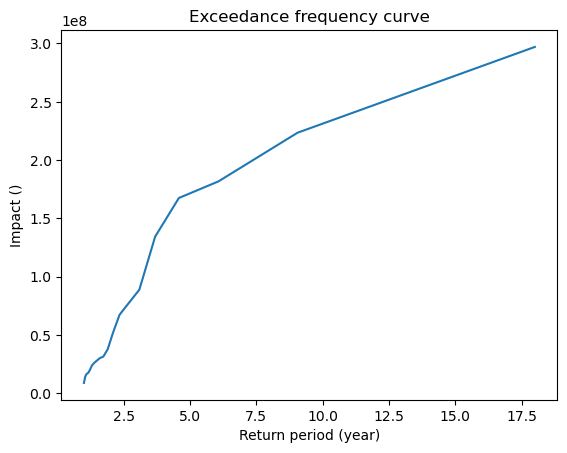

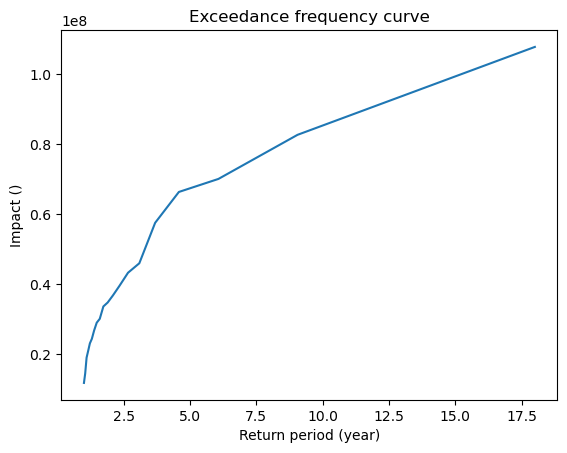

In [144]:
imp_vkg_freq_curve = imp_vkg.calc_freq_curve(return_per = cp.copy(return_period))
imp_vkg_freq_curve.plot()

imp_sturm_complet_freq_curve = imp_sturm_complet.calc_freq_curve(return_per = cp.copy(return_period))
imp_sturm_complet_freq_curve.plot()




In [135]:
Optimization_results = []
def create_dict(*args):
  return dict({i:eval(i) for i in args})

In [136]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [137]:
def spearmanr_ci(x, y, alpha=0.05):
    r, p = stats.spearmanr(x, y)
    r_z = np.arctanh(r)
    se = np.sqrt((1+r**2/2)/(x.size-3))
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# First Result

Lets first start with infrastructure and a constant imp_fun. So when there is a hail event in the data (POH=1 and MESHS > 2cm) there will be a constant damage

In [14]:
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "infr" # ["infr", "agr"]
optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "const" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_meshs.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.01,0.03)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.01_1,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0.000_000,0.001_0,0.000_001)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


Optimization_results.append(create_dict("sector", 
                                        "optimize_type", 
                                        "score_type", 
                                        "type_imp_fun", 
                                        "norm", 
                                        "class_mult", 
                                        "num_fct", 
                                        "bounds", 
                                        "optimize_results"))
    

2021-03-11 13:03:40,749 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:40,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:40,754 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.11582188900001711
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.])}]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.3038633054443336, 0.2202452537056309)
pearson for agr  (score, p_value) = (-0.18825862454006537, 0.4543989805959836)
RMSF:  484594692.1296334
RMSE 1.5009959327256334e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:40,871 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consid

2021-03-11 13:03:42,086 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1486444530000881
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([9.e-06])}]
The sum of the new Impact is: 1.52e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  7.832974875864333
RMSE 1.3498904865344116e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:42,237 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:42,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:42,240 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
t

2021-03-11 13:03:43,656 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:43,658 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14599063400009982
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([1.9e-05])}]
The sum of the new Impact is: 3.20e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  4.21105595787787
RMSE 1.2006491952973104e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:43,806 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:43,807 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:03:45,176 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:45,179 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14532650399996783
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([2.9e-05])}]
The sum of the new Impact is: 4.89e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748695, 0.21631181760733662)
RMSF:  3.1738588915429204
RMSE 1.071043326044586e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:45,328 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:45,328 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:03:46,708 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:46,711 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1470534050004062
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([3.9e-05])}]
The sum of the new Impact is: 6.57e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  2.7635640015715315
RMSE 9610728787762390.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:46,860 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:46,860 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:

2021-03-11 13:03:48,241 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:48,243 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14445047400022304
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([4.9e-05])}]
The sum of the new Impact is: 8.26e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  2.6114955140389764
RMSE 8707378534922686.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:48,390 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:48,390 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:03:49,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:49,754 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14660083099988697
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([5.9e-05])}]
The sum of the new Impact is: 9.94e+08
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  2.592268829718673
RMSE 8000382501926749.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:49,902 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:49,903 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:0

2021-03-11 13:03:51,273 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:51,276 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14696405199993023
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([6.9e-05])}]
The sum of the new Impact is: 1.16e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  2.6489542008217057
RMSE 7489740688774585.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:51,425 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:51,427 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13

2021-03-11 13:03:52,788 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:52,791 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14455368200015073
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([7.9e-05])}]
The sum of the new Impact is: 1.33e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748704, 0.21631181760733534)
RMSF:  2.751624370753038
RMSE 7175453095466183.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:52,938 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:52,938 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:

2021-03-11 13:03:54,307 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:54,310 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14590752499998416
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([8.9e-05])}]
The sum of the new Impact is: 1.50e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748696, 0.21631181760733662)
RMSF:  2.88335912387068
RMSE 7057519722001558.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:54,458 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:54,459 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:0

2021-03-11 13:03:55,849 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:55,852 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.15025399500018466
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([9.9e-05])}]
The sum of the new Impact is: 1.67e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  3.034153217930233
RMSE 7135940568380698.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:56,005 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:56,006 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:

2021-03-11 13:03:57,595 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:57,598 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14983149200043044
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000109])}]
The sum of the new Impact is: 1.84e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  3.1978686131390277
RMSE 7410715634603604.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:57,750 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:57,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:03:59,195 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:03:59,198 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.15604346500003885
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000119])}]
The sum of the new Impact is: 2.01e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  3.3706090833924307
RMSE 7881844920670283.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:03:59,357 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:03:59,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:04:00,827 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:00,829 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14478283900007227
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000129])}]
The sum of the new Impact is: 2.17e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  3.5498210763318854
RMSE 8549328426580729.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:00,977 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:00,978 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:04:02,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:02,360 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14615259399988645
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000139])}]
The sum of the new Impact is: 2.34e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  3.7337809323281728
RMSE 9413166152334940.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:02,510 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:02,511 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:04:03,895 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:03,898 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14059662799991202
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000149])}]
The sum of the new Impact is: 2.51e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  3.9212936130550125
RMSE 1.0473358097932924e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:04,041 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:04,042 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.14111084499973003
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000158])}]
The sum of the new Impact is: 2.66e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748704, 0.21631181760733534)
RMSF:  4.0923860527991875
RMSE 1.1595413706937524e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:05,390 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:05,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:05,395 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1422105259998716
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:04:06,730 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:06,733 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14342506299999513
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000168])}]
The sum of the new Impact is: 2.83e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486924, 0.2163118176073371)
RMSF:  4.28450504923292
RMSE 1.302867867023868e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:06,878 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:06,879 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:08,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:08,243 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.15412937800010695
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000178])}]
The sum of the new Impact is: 3.00e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748696, 0.21631181760733662)
RMSF:  4.478296728075566
RMSE 1.4658297853383592e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:08,399 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:08,400 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.14046005099999093
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000187])}]
The sum of the new Impact is: 3.15e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  4.653846364484348
RMSE 1.6292837976180434e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:09,754 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:09,754 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:09,757 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14415678900013518
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1

2021-03-11 13:04:11,220 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:11,222 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14243305400032114
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000197])}]
The sum of the new Impact is: 3.32e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  4.849915142007792
RMSE 1.8295530177028508e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:11,368 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:11,370 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

2021-03-11 13:04:12,863 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:12,867 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14409474700005376
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000207])}]
The sum of the new Impact is: 3.49e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  5.04684632218138
RMSE 2.0494576597720324e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:13,012 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:13,013 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14143454100030795
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000216])}]
The sum of the new Impact is: 3.64e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  5.224683265455406
RMSE 2.2641601234309428e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:14,563 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:14,564 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:14,567 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14720225700011724
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1

2021-03-11 13:04:16,131 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:16,134 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1503660180001134
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000226])}]
The sum of the new Impact is: 3.81e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  5.422822983394547
RMSE 2.5213720672704424e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:16,286 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:16,287 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:04:17,693 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:17,696 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14084438400004728
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000236])}]
The sum of the new Impact is: 3.98e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  5.62143104005219
RMSE 2.7982194330943188e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:17,838 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:17,839 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:19,190 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:19,194 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14314834400011023
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000246])}]
The sum of the new Impact is: 4.15e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  5.820420827938554
RMSE 3.094702220902571e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:19,339 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:19,340 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:04:20,703 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:20,705 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14208755099980408
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000256])}]
The sum of the new Impact is: 4.31e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  6.0197220391863215
RMSE 3.410820430695205e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:20,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:20,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.148466137000014
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000265])}]
The sum of the new Impact is: 4.47e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486947, 0.21631181760733662)
RMSF:  6.19931165304099
RMSE 3.712115105305215e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:22,204 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:22,204 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:22,207 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1449553239999659
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_

2021-03-11 13:04:23,561 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:23,564 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14304021099997044
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000275])}]
The sum of the new Impact is: 4.63e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  6.3990545995005
RMSE 4.065540616868162e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:23,709 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:23,710 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:04:25,064 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:25,067 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14542153399997915
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000285])}]
The sum of the new Impact is: 4.80e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  6.598968523980005
RMSE 4.438601550415484e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:25,215 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:25,216 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

2021-03-11 13:04:26,580 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:26,583 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14547572700030287
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000295])}]
The sum of the new Impact is: 4.97e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748694, 0.21631181760733664)
RMSF:  6.799020177820004
RMSE 4.831297905947187e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:26,730 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:26,731 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:04:28,071 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:28,074 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.144669994999731
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000305])}]
The sum of the new Impact is: 5.14e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  6.999181749211338
RMSE 5.2436296834632616e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:28,221 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:28,222 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:29,601 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:29,604 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.13997318199972142
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000315])}]
The sum of the new Impact is: 5.31e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486947, 0.21631181760733662)
RMSF:  7.199429870562088
RMSE 5.675596882963712e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:29,747 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:29,748 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

2021-03-11 13:04:31,085 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:31,088 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1426194629998463
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000325])}]
The sum of the new Impact is: 5.48e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  7.399744830084073
RMSE 6.127199504448549e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:31,233 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:31,234 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:32,581 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:32,584 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14553145700028836
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000335])}]
The sum of the new Impact is: 5.64e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748695, 0.21631181760733662)
RMSF:  7.600109940867199
RMSE 6.598437547917756e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:32,733 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:32,734 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:04:34,086 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:34,089 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14317074599966872
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000345])}]
The sum of the new Impact is: 5.81e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487035, 0.21631181760733534)
RMSF:  7.800511032437654
RMSE 7.089311013371345e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:34,234 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:34,235 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

2021-03-11 13:04:35,562 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:35,566 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14722830300024725
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000355])}]
The sum of the new Impact is: 5.98e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  8.000936038334645
RMSE 7.599819900809304e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:35,715 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:35,716 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:37,060 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:37,063 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1433891249998851
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000365])}]
The sum of the new Impact is: 6.15e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748696, 0.21631181760733662)
RMSF:  8.201374659520951
RMSE 8.129964210231651e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:37,208 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:37,209 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:38,552 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:38,554 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1567492169997422
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000375])}]
The sum of the new Impact is: 6.32e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486924, 0.2163118176073371)
RMSF:  8.401818088105012
RMSE 8.67974394163836e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:38,715 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:38,716 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:04:40,067 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:40,069 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1430988150000303
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000385])}]
The sum of the new Impact is: 6.49e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  8.602258779345688
RMSE 9.249159095029446e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:40,215 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:40,216 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:04:41,568 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:41,572 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14292548599996735
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000395])}]
The sum of the new Impact is: 6.66e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  8.802690262549262
RMSE 9.838209670404915e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:41,717 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:41,719 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:04:43,057 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:43,059 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14080869600002188
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000405])}]
The sum of the new Impact is: 6.82e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  9.003106983477863
RMSE 1.0446895667764768e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:43,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:43,204 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.14286441399963223
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000414])}]
The sum of the new Impact is: 6.98e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  9.183465454040917
RMSE 1.101150135118526e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:44,554 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:44,555 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:44,558 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14655438899990259
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:04:45,889 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:45,892 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14598211099973923
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000424])}]
The sum of the new Impact is: 7.14e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487, 0.2163118176073359)
RMSF:  9.38384154488605
RMSE 1.1657494650315435e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:46,040 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:46,041 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13

2021-03-11 13:04:47,386 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:47,388 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1423000210002101
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000434])}]
The sum of the new Impact is: 7.31e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  9.584190819538092
RMSE 1.2323123371429971e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:47,533 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:47,533 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14280480800016448
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000443])}]
The sum of the new Impact is: 7.46e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  9.764479698674341
RMSE 1.2938977506229686e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:48,883 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:48,884 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:48,887 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14167790200008312
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:04:50,228 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:50,231 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14309250499991322
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000453])}]
The sum of the new Impact is: 7.63e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748712, 0.21631181760733387)
RMSF:  9.964769951009988
RMSE 1.3641913529114554e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:50,377 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:50,378 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.1408237040000131
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000462])}]
The sum of the new Impact is: 7.78e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487035, 0.21631181760733534)
RMSF:  10.145001709582013
RMSE 1.4291344235507562e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:51,715 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:51,716 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:51,718 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14087452600006145
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1

2021-03-11 13:04:53,058 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:53,061 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14264924700000847
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000472])}]
The sum of the new Impact is: 7.95e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  10.345224679638006
RMSE 1.503158756016273e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:53,206 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:53,207 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.1441325420000794
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000481])}]
The sum of the new Impact is: 8.11e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  10.525392929955926
RMSE 1.571459483814903e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:54,546 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:54,547 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:54,549 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14632483500008675
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:04:55,912 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:55,915 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1423453430002155
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000491])}]
The sum of the new Impact is: 8.27e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  10.725542536624355
RMSE 1.6492145464574528e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:56,059 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:56,059 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.1438989709999987
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.0005])}]
The sum of the new Impact is: 8.43e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  10.905642610322161
RMSE 1.720872931415411e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:57,411 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:57,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:57,414 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1404347930001677
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_

2021-03-11 13:04:58,767 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:04:58,770 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.146897978999732
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.00051])}]
The sum of the new Impact is: 8.59e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.306344141174869, 0.21631181760733723)
RMSF:  11.10571445054082
RMSE 1.8023587242349894e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:04:58,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:04:58,919 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13

time to calc impact:  0.1493534690002889
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000519])}]
The sum of the new Impact is: 8.75e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  11.285743007246136
RMSE 1.8773747663522768e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:00,293 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:00,294 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:00,297 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14748232200008715
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:05:01,668 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:01,671 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14695196200000282
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000529])}]
The sum of the new Impact is: 8.91e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486936, 0.2163118176073371)
RMSF:  11.485733977448197
RMSE 1.9625912893488906e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:01,821 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:01,821 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.14916604700010794
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000538])}]
The sum of the new Impact is: 9.07e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748691, 0.21631181760733723)
RMSF:  11.665688707613903
RMSE 2.040964988625504e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:03,177 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:03,178 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:03,180 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14293543700023292
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:05:04,515 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:04,517 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14144353099982254
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000548])}]
The sum of the new Impact is: 9.23e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  11.865596715007364
RMSE 2.1299122417991488e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:04,661 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:04,662 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.14296528699969713
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000557])}]
The sum of the new Impact is: 9.39e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486963, 0.21631181760733678)
RMSF:  12.045476112315484
RMSE 2.2116435982350912e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:05,994 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:05,995 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:05,998 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14188178199992763
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 

2021-03-11 13:05:07,329 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:07,332 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14171917100020437
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000567])}]
The sum of the new Impact is: 9.55e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  12.245299852886742
RMSE 2.3043215815857667e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:07,476 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:07,477 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.14418264500000078
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000576])}]
The sum of the new Impact is: 9.71e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  12.425103038593667
RMSE 2.389410595181039e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:08,844 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:08,845 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:08,847 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14257423500021105
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:05:10,177 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:10,180 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14296204299989768
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000586])}]
The sum of the new Impact is: 9.87e+09
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748702, 0.2163118176073356)
RMSF:  12.62484182516856
RMSE 2.4858193087087446e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:10,325 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:10,326 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14368562899971948
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000595])}]
The sum of the new Impact is: 1.00e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486897, 0.2163118176073374)
RMSF:  12.804568411600197
RMSE 2.574265979463345e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:11,670 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:11,671 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:11,674 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14283216400008314
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:05:13,034 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:13,037 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14160978099971544
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000605])}]
The sum of the new Impact is: 1.02e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748702, 0.2163118176073356)
RMSF:  13.00422203980358
RMSE 2.6744054231680832e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:13,181 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:13,181 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.1434913940001934
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000614])}]
The sum of the new Impact is: 1.03e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  13.18387202361852
RMSE 2.7662097510820118e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:14,543 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:14,544 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:14,547 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14623891800010824
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:05:15,894 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:15,896 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1428171200000179
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000624])}]
The sum of the new Impact is: 1.05e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748697, 0.21631181760733634)
RMSF:  13.383440666768463
RMSE 2.870079924963783e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:16,042 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:16,042 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.1444190580000395
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000633])}]
The sum of the new Impact is: 1.07e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  13.563014345038226
RMSE 2.965241910037038e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:17,392 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:17,393 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:17,396 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14460875299982945
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

2021-03-11 13:05:18,748 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:18,750 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14309866299981877
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000643])}]
The sum of the new Impact is: 1.08e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  13.762498471302269
RMSE 3.0728428140958406e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:18,897 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:18,898 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.14517499700014014
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000652])}]
The sum of the new Impact is: 1.10e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748708, 0.2163118176073348)
RMSF:  13.941996375210644
RMSE 3.171362456328427e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:20,245 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:20,246 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:20,248 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14187799999990602
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:05:21,599 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:21,602 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14475664100018548
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000662])}]
The sum of the new Impact is: 1.12e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487013, 0.2163118176073356)
RMSF:  14.14139668201219
RMSE 3.282694090564258e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:21,749 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:21,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:05:23,107 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:23,110 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14202083500003937
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000672])}]
The sum of the new Impact is: 1.13e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486924, 0.2163118176073371)
RMSF:  14.340753215117216
RMSE 3.3959892669985306e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:23,254 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:23,255 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.16923628299991833
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000681])}]
The sum of the new Impact is: 1.15e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  14.5201368861316
RMSE 3.4996337543690394e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:24,627 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:24,628 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:24,631 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14187876200003302
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1,

2021-03-11 13:05:25,981 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:25,984 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14132213600032628
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000691])}]
The sum of the new Impact is: 1.16e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  14.719410991317904
RMSE 3.616659660980341e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:26,127 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:26,128 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.14279377799994108
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.0007])}]
The sum of the new Impact is: 1.18e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486897, 0.2163118176073374)
RMSF:  14.898720946051476
RMSE 3.723661805510177e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:27,470 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:27,471 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:27,474 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1438639590001003
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y

2021-03-11 13:05:28,819 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:28,822 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14578927000002295
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.00071])}]
The sum of the new Impact is: 1.20e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748699, 0.2163118176073359)
RMSF:  15.097913690915128
RMSE 3.844418442298512e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:28,970 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:28,971 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

time to calc impact:  0.1421623199998976
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000719])}]
The sum of the new Impact is: 1.21e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748705, 0.21631181760733534)
RMSF:  15.27715093261346
RMSE 3.954778243987678e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:30,309 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:30,310 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:30,314 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1446330769999804
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y

2021-03-11 13:05:31,658 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:31,661 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14282582699979685
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000729])}]
The sum of the new Impact is: 1.23e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486963, 0.21631181760733678)
RMSF:  15.476263472274278
RMSE 4.079265610953042e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:31,806 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:31,807 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.1413448650000646
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000738])}]
The sum of the new Impact is: 1.24e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748696, 0.21631181760733662)
RMSF:  15.655429071678043
RMSE 4.192983069801535e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:33,150 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:33,151 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:33,153 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.144408552999721
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y

2021-03-11 13:05:34,497 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:34,499 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14105057799997667
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000748])}]
The sum of the new Impact is: 1.26e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  15.854462625047322
RMSE 4.321201166943932e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:34,643 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:34,644 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.14334806699980618
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000757])}]
The sum of the new Impact is: 1.28e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  16.03355770125686
RMSE 4.4382762829517536e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:35,997 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:35,998 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:36,001 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14384026600009747
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1

2021-03-11 13:05:37,350 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:37,353 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1430282729997998
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000767])}]
The sum of the new Impact is: 1.29e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748704, 0.21631181760733534)
RMSF:  16.23251353198147
RMSE 4.5702251102711834e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:37,499 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:37,500 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14285655799994856
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000776])}]
The sum of the new Impact is: 1.31e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748703, 0.21631181760733528)
RMSF:  16.4115392370876
RMSE 4.690657883438329e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:38,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:38,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:38,853 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14220197199983886
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

2021-03-11 13:05:40,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:40,201 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14265830700014703
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000786])}]
The sum of the new Impact is: 1.32e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486886, 0.21631181760733773)
RMSF:  16.610418638243345
RMSE 4.826337440934792e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:40,345 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:40,346 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-11 13:05:41,686 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:41,689 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14300830999991376
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000796])}]
The sum of the new Impact is: 1.34e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748691, 0.21631181760733723)
RMSF:  16.8092583389068
RMSE 4.963980540629693e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:41,834 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:41,834 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

time to calc impact:  0.14172395000014149
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000805])}]
The sum of the new Impact is: 1.36e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  16.98818042678465
RMSE 5.089538158934761e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:43,174 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:43,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:43,177 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14580714999965494
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 

2021-03-11 13:05:44,566 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:44,570 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1442276990001119
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000815])}]
The sum of the new Impact is: 1.37e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  17.186945701147316
RMSE 5.230911988806696e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:44,716 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:44,717 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14222879099997954
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000824])}]
The sum of the new Impact is: 1.39e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487, 0.2163118176073359)
RMSF:  17.365801398580842
RMSE 5.359827264271097e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:46,071 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:46,072 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:46,075 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14560081099989475
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y

2021-03-11 13:05:47,421 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:47,423 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1430721579999954
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000834])}]
The sum of the new Impact is: 1.41e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748692, 0.2163118176073374)
RMSF:  17.56449356469863
RMSE 5.504931824320057e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:47,570 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:47,571 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

time to calc impact:  0.143478044999938
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000843])}]
The sum of the new Impact is: 1.42e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486963, 0.21631181760733678)
RMSF:  17.74328405681209
RMSE 5.637204756943789e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:48,917 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:48,917 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:48,920 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14344939700004034
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

2021-03-11 13:05:50,265 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:50,267 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14390812700003153
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000853])}]
The sum of the new Impact is: 1.44e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  17.941904428654315
RMSE 5.786040047169782e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:50,414 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:50,415 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.143477189999885
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000862])}]
The sum of the new Impact is: 1.45e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748693, 0.2163118176073371)
RMSF:  18.12063089424163
RMSE 5.921670636952831e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:51,763 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:51,764 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:51,766 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.148229585000081
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_co

2021-03-11 13:05:53,114 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:53,116 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14118775499991898
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000872])}]
The sum of the new Impact is: 1.47e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748701, 0.21631181760733587)
RMSF:  18.319180776125155
RMSE 6.074236657355862e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:53,260 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:53,261 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-1

time to calc impact:  0.140737616000024
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000881])}]
The sum of the new Impact is: 1.48e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487047, 0.21631181760733534)
RMSF:  18.49784438319361
RMSE 6.213224904298245e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:54,601 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:54,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:54,605 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14454113500005406
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

2021-03-11 13:05:55,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:55,957 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14284188299961897
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000891])}]
The sum of the new Impact is: 1.50e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748708, 0.2163118176073348)
RMSF:  18.696325065384904
RMSE 6.369521654878309e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:56,103 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:56,103 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14447741200001474
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.0009])}]
The sum of the new Impact is: 1.52e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748705, 0.21631181760733534)
RMSF:  18.87492696764769
RMSE 6.511867558980019e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:57,453 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:57,454 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:57,457 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1431000289999247
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_

2021-03-11 13:05:58,819 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:05:58,822 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14435875299977852
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.00091])}]
The sum of the new Impact is: 1.53e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  19.073339722917293
RMSE 6.671895039737108e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:05:58,968 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:05:58,969 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

2021-03-11 13:06:00,319 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:00,322 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14456804900009956
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.00092])}]
The sum of the new Impact is: 1.55e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748702, 0.2163118176073356)
RMSF:  19.271717231666873
RMSE 6.833886062692632e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:00,469 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:00,470 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

time to calc impact:  0.14462003900007403
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000929])}]
The sum of the new Impact is: 1.57e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486947, 0.21631181760733662)
RMSF:  19.450227138014927
RMSE 6.981356811932268e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:01,806 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:01,807 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:01,810 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14398971399987204
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1

2021-03-11 13:06:03,157 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:03,160 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1422125799999776
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000939])}]
The sum of the new Impact is: 1.58e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748694, 0.21631181760733664)
RMSF:  19.648538622907303
RMSE 7.147078565064832e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:03,305 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:03,306 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11

time to calc impact:  0.14361108299999614
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000948])}]
The sum of the new Impact is: 1.60e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117487, 0.2163118176073359)
RMSF:  19.826989658645576
RMSE 7.297906971463796e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:04,652 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:04,653 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:04,655 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1421334609999576
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_

2021-03-11 13:06:05,992 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:05,995 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14189194100026725
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000958])}]
The sum of the new Impact is: 1.61e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486986, 0.21631181760733595)
RMSF:  20.025236337770885
RMSE 7.467359454773381e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:06,140 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:06,141 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.1447923229998196
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000967])}]
The sum of the new Impact is: 1.63e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486974, 0.21631181760733634)
RMSF:  20.20362958835419
RMSE 7.621545518331676e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:07,494 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:07,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:07,498 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1416118360002656
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

2021-03-11 13:06:08,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:08,894 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1427097790001426
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000977])}]
The sum of the new Impact is: 1.65e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  20.40181265547064
RMSE 7.794728731818298e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:09,040 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:09,041 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:06:10,392 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:10,395 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1449733899999046
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000987])}]
The sum of the new Impact is: 1.66e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.3063441411748698, 0.21631181760733634)
RMSF:  20.599962713562462
RMSE 7.96987548750335e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:10,543 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:10,544 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

time to calc impact:  0.14373649100025432
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, 'y_const': array([0.000996])}]
The sum of the new Impact is: 1.68e+10
spearman for agr  (score, p_value) = (0.4262125902992776, 0.07778293683965698)
pearson for agr  (score, p_value) = (0.30634414117486997, 0.2163118176073359)
RMSF:  20.77826980764617
RMSE 8.12918639619957e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:11,962 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:11,963 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:11,965 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14639288600028522
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 1, '

In [15]:
Optimization_results

[{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.001, 1e-06)],
  'optimize_results': 5.6e-05}]

Lets look at all "usefull" results,
{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(5e-05, 0.0001, 1e-06)],
  'optimize_results': 5.5999999999999986e-05}
  
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSE',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.001, 1e-06)],
  'optimize_results': 8.999999999999999e-05}]

and visualize them in the next panel

2021-03-11 15:06:52,549 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 15:06:52,551 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 15:06:52,553 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 52424149.9582802
Correlation of the RMSF data for spearman is 0.4262125902992776 with upper limit 0.7547074102931423 and lower limit -0.07315321008405272 with p value of 0.07778293683965698
Correlation of the RMSF data for pearson is 0.30634414117487063 with upper limit 0.6764643183279397 and lower limit -0.18731648101911597 with a p value of 0.2163118176073351
RMSF is 2.58819011604362


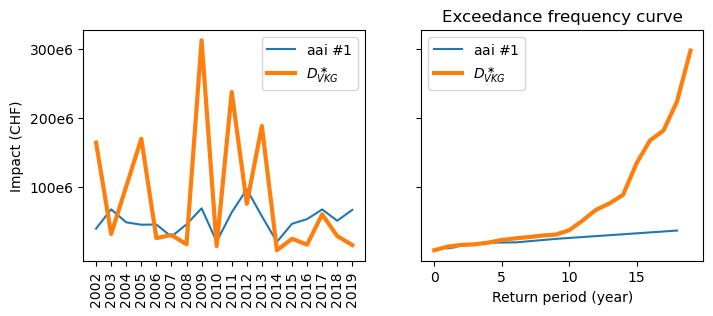

In [147]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib

y = np.zeros(150)
y[:] = 5.6e-05
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))

#plot

plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_vkg, linewidth = 3)
axs[0].legend([r"aai $\# 1$", r"$D_{VKG}^\ast$"])

freq_curve = imp_RMSF.calc_freq_curve(return_per = cp.copy(return_period))
freq_curve.unit = "CHF"
freq_curve.plot(axis=axs[1])
axs[1].plot(imp_vkg_freq_curve.impact, linewidth = 3)
axs[1].legend([r"aai $\# 1$", r"$D_{VKG}^\ast$"])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0].set_yticklabels(labels=["100e6","200e6","300e6"])
axs[1].set_ylabel("")

matplotlib.rcParams.update(matplotlib.rcParamsDefault)



Lets do the same with Agriculture

In [17]:
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "agr" # ["infr", "agr"]
optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "const" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_agr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.01,0.03)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.01_1,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0.000_000,0.200_0,0.001_0)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


Optimization_results.append(create_dict("sector", 
                                        "optimize_type", 
                                        "score_type", 
                                        "type_imp_fun", 
                                        "norm", 
                                        "class_mult", 
                                        "num_fct", 
                                        "bounds", 
                                        "optimize_results"))
    

2021-03-11 13:06:13,694 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:13,695 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:13,703 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.4946826529999271
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.])}]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:14,195 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Conside

2021-03-11 13:06:20,895 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8238961129995914
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.009])}]
The sum of the new Impact is: 2.72e+08
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395709, 0.1266569148978525)
RMSF:  2.9422043539190095
RMSE 1393466869309781.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:21,717 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:21,718 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:21,726 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time

2021-03-11 13:06:29,289 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:29,297 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.829309018999993
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.019])}]
The sum of the new Impact is: 5.75e+08
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703958243, 0.12665691489783978)
RMSF:  1.8150238032922423
RMSE 732376275417504.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:30,125 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:30,126 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06

2021-03-11 13:06:37,626 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:37,633 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8291255940002884
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.029])}]
The sum of the new Impact is: 8.77e+08
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395991, 0.12665691489782166)
RMSF:  1.8705127856741912
RMSE 707940257962521.6
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:38,461 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:38,463 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06

2021-03-11 13:06:45,975 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:45,982 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8284083019998434
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.039])}]
The sum of the new Impact is: 1.18e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703956184, 0.12665691489786235)
RMSF:  2.212989583355652
RMSE 1320158816944812.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:46,808 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:46,809 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:0

2021-03-11 13:06:54,308 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:54,316 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.82278207499985
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.049])}]
The sum of the new Impact is: 1.48e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703957244, 0.12665691489785091)
RMSF:  2.629548242542213
RMSE 2569031952363944.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:06:55,137 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:06:55,137 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:06:

2021-03-11 13:07:02,647 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:02,655 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8356138859999191
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.059])}]
The sum of the new Impact is: 1.79e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703955407, 0.12665691489787098)
RMSF:  3.0707940849323703
RMSE 4454559664221002.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:03,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:03,489 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:

2021-03-11 13:07:10,993 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:11,000 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8221361199998682
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.069])}]
The sum of the new Impact is: 2.09e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470396001, 0.12665691489782058)
RMSF:  3.5224750489222103
RMSE 6976741952516412.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:11,820 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:11,821 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:0

2021-03-11 13:07:19,604 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:19,612 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8282831070000611
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.079])}]
The sum of the new Impact is: 2.39e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395848, 0.12665691489783723)
RMSF:  3.979298854050661
RMSE 1.0135578817245102e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:20,438 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:20,439 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:07:27,957 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:27,964 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8254430719998709
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.089])}]
The sum of the new Impact is: 2.69e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395417, 0.1266569148978845)
RMSF:  4.438917345857363
RMSE 1.3931070258412706e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:28,788 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:28,788 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13

2021-03-11 13:07:36,239 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:36,246 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8282495559997187
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.099])}]
The sum of the new Impact is: 3.00e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703958743, 0.12665691489783437)
RMSF:  4.900151954142725
RMSE 1.8363216276022664e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:37,073 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:37,073 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:07:44,624 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:44,631 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8210911149999447
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.109])}]
The sum of the new Impact is: 3.30e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703960053, 0.12665691489782005)
RMSF:  5.3623565499984664
RMSE 2.343201687006261e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:45,450 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:45,451 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:07:52,957 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:07:52,965 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8207950369996979
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.119])}]
The sum of the new Impact is: 3.60e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395677, 0.12665691489785605)
RMSF:  5.8251530246940995
RMSE 2.9137472040544744e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:07:53,783 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:07:53,784 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 

2021-03-11 13:08:01,331 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:01,338 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8223847569997815
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.129])}]
The sum of the new Impact is: 3.90e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703958044, 0.1266569148978421)
RMSF:  6.288308918346083
RMSE 3.5479581787464412e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:02,159 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:02,160 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:08:09,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:09,654 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8236779380004009
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.139])}]
The sum of the new Impact is: 4.21e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703959404, 0.1266569148978271)
RMSF:  6.751675803990345
RMSE 4.2458346110819656e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:10,475 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:10,476 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:08:17,964 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:17,971 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8240059919999112
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.149])}]
The sum of the new Impact is: 4.51e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395695, 0.1266569148978541)
RMSF:  7.215156114123944
RMSE 5.007376501060696e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:18,793 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:18,794 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:

2021-03-11 13:08:26,323 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:26,331 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8417381940002997
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.159])}]
The sum of the new Impact is: 4.81e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703957544, 0.12665691489784747)
RMSF:  7.67868428346931
RMSE 5.8325838486838456e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:27,170 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:27,171 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:08:34,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:34,734 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8210160720000204
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.169])}]
The sum of the new Impact is: 5.11e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.3736539470395749, 0.126656914897848)
RMSF:  8.142215538196924
RMSE 6.721456653950453e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:35,553 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:35,553 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:0

2021-03-11 13:08:43,040 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:43,047 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8270981509999729
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.179])}]
The sum of the new Impact is: 5.42e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703957644, 0.12665691489784658)
RMSF:  8.605718976087298
RMSE 7.673994916860515e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:43,872 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:43,873 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:08:51,396 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:51,404 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8342703040002561
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.189])}]
The sum of the new Impact is: 5.72e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703957344, 0.12665691489784972)
RMSF:  9.069173157241728
RMSE 8.690198637414534e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:08:52,236 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:08:52,237 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 1

2021-03-11 13:08:59,773 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:08:59,780 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  0.8356501620000927
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 2, 'y_const': array([0.199])}]
The sum of the new Impact is: 6.02e+09
spearman for agr  (score, p_value) = (0.2714138286893705, 0.27595238461589006)
pearson for agr  (score, p_value) = (0.37365394703955773, 0.12665691489786698)
RMSF:  9.532563217019362
RMSE 9.770067815612448e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0.022
RMSF
meshs


In [18]:
Optimization_results

[{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.001, 1e-06)],
  'optimize_results': 5.6e-05},
 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.001)],
  'optimize_results': 0.022}]

Lets look at the usefull results:

 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.002)],
  'optimize_results': 0.022},
 
 
 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSE',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.002)],
  'optimize_results': 0.024}]
  

2021-03-11 15:26:41,388 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 15:26:41,389 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 15:26:41,398 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


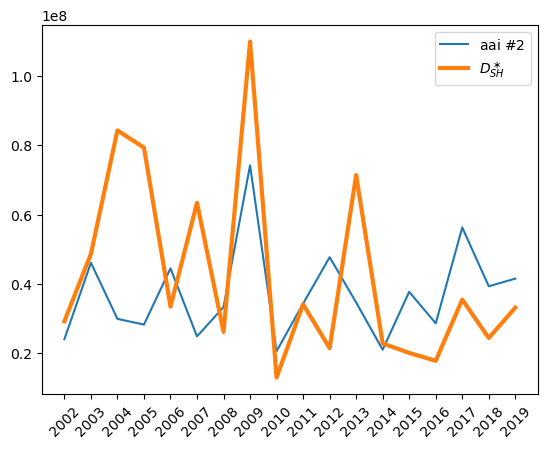

aai_agg = 36981259.34943567
RMSF is 1.7724440689865437
Correlation of the RMSF data for spearman is 0.2714138286893705 with upper limit 0.6604917997016324 and lower limit -0.23257177786524544 with p value of 0.27595238461589006
Correlation of the RMSF data for pearson is 0.37365394559579873 with upper limit 0.7156759006022879 and lower limit -0.11291367542337652 with a p value of 0.12665691648113725
RMSF is 2.8943086305682075


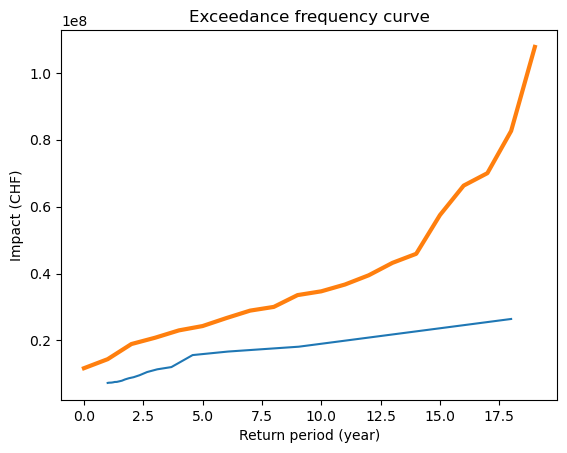

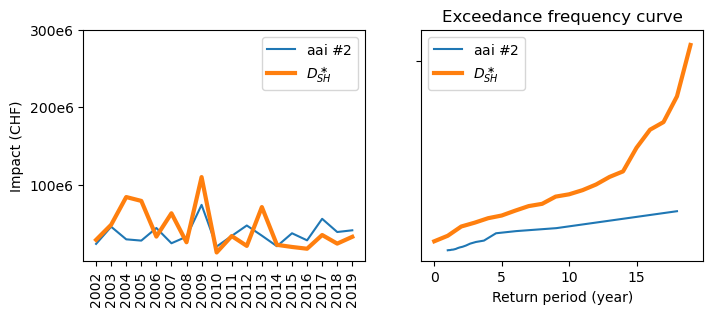

In [150]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

y = np.zeros(150)
y[:] = 0.022
exp_agr["if_HL"]=10
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         10,
                                         0,
                                         0,
                                         0,
                                         y))

imp_agr_RMSF = Impact()
imp_agr_RMSF.calc(exp_agr, ifset_hail, haz_real, save_mat=True)

#plot
plt.figure()
plt.plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
plt.xticks(rotation = 45)
plt.show()

Y_RMSF = list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())


print("aai_agg = {}".format(imp_agr_RMSF.aai_agg))

print("RMSF is {}".format(fct.RMSF(dmg_from_sturmarchiv, Y_RMSF)))

spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))

freq_curve = imp_agr_RMSF.calc_freq_curve(return_per = cp.copy(return_period))
freq_curve.unit = "CHF"
freq_curve.plot()
plt.plot(imp_sturm_complet_freq_curve.impact, linewidth = 3)

plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_sturmarchiv, linewidth = 3)
axs[0].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])

freq_curve = imp_agr_RMSF.calc_freq_curve(return_per = cp.copy(return_period))
freq_curve.unit = "CHF"
freq_curve.plot(axis=axs[1])
axs[1].plot(imp_sturm_complet_freq_curve.impact, linewidth = 3)
axs[1].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
axs[1].set_ylabel("")

axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0].set_yticklabels(labels=["100e6","200e6","300e6"])

matplotlib.rcParams.update(matplotlib.rcParamsDefault)


# Class Infr

## Class 1

In [20]:
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "infr" # ["infr", "agr"]
optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "class" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_meshs.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.01,0.03)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,1),
                  slice(0,1,1),
                  slice(0,1,1),
                  slice(0,1,1)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.003,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0.000_000,0.200_0,0.002_0)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


Optimization_results.append(create_dict("sector", 
                                        "optimize_type", 
                                        "score_type", 
                                        "type_imp_fun", 
                                        "norm", 
                                        "class_mult", 
                                        "num_fct", 
                                        "bounds", 
                                        "optimize_results"))
    

2021-03-11 13:09:05,128 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:05,129 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:05,132 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.10981072100003075
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0. 0. 0. 0. 0.]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.3038633054443336, 0.2202452537056309)
pearson for agr  (score, p_value) = (-0.18825862454006537, 0.4543989805959836)
RMSF:  484594692.1296334
RMSE 1.5009959327256334e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:09:05,246 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin 

2021-03-11 13:09:06,171 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1087349469999026
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.0009]
The sum of the new Impact is: 6.26e+08
spearman for agr  (score, p_value) = (0.28792569659442724, 0.2466148887955486)
pearson for agr  (score, p_value) = (0.200981667048767, 0.4238918568520129)
RMSF:  5.14732308486818
RMSE 1.0296152994789786e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:09:06,281 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:06,282 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:06,285 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to cal

2021-03-11 13:09:07,309 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:07,312 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.10979612400024052
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.0019]
The sum of the new Impact is: 1.32e+09
spearman for agr  (score, p_value) = (0.28792569659442724, 0.2466148887955486)
pearson for agr  (score, p_value) = (0.20098166704876683, 0.42389185685201325)
RMSF:  3.9644841009994805
RMSE 1.0807588246257362e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-11 13:09:07,424 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:07,425 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09

2021-03-11 13:09:08,458 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:08,461 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.10520880399963062
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.0029]
The sum of the new Impact is: 2.02e+09
spearman for agr  (score, p_value) = (0.28792569659442724, 0.2466148887955486)
pearson for agr  (score, p_value) = (0.20098166704876727, 0.4238918568520124)
RMSF:  4.03539298069771
RMSE 1.7370600194772256e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.     0.     0.     0.     0.0022]
RMSF
meshs


Class 1 results:
 {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 0.0002, 1e-05),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1)],
  'optimize_results': array([0.00014, 0.     , 0.     , 0.     , 0.     ])}]
  
 Class 2 results:
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 0.0002, 1e-05),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1)],
  'optimize_results': array([0.     , 0.00017, 0.     , 0.     , 0.     ])}]
  
 Class 3 results:
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 0.0004, 1e-05),
   slice(0, 1, 1),
   slice(0, 1, 1)],
  'optimize_results': array([0.     , 0.     , 0.00034, 0.     , 0.     ])}]
  
 Class 4
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 0.002, 0.0001),
   slice(0, 1, 1)],
  'optimize_results': array([0.    , 0.    , 0.    , 0.0011, 0.    ])}]
  
 Class 5
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 0.003, 0.0001)],
  'optimize_results': array([0.    , 0.    , 0.    , 0.    , 0.0022])}]

In [21]:
Optimization_results

[{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.001, 1e-06)],
  'optimize_results': 5.6e-05},
 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.001)],
  'optimize_results': 0.022},
 {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 0.003, 0.0001)],
  'optimize_results': array([0.    , 0.    , 0.    , 0.    , 0.0022])}]

2021-03-11 13:09:08,589 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:08,591 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:08,594 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 52677975.71235706


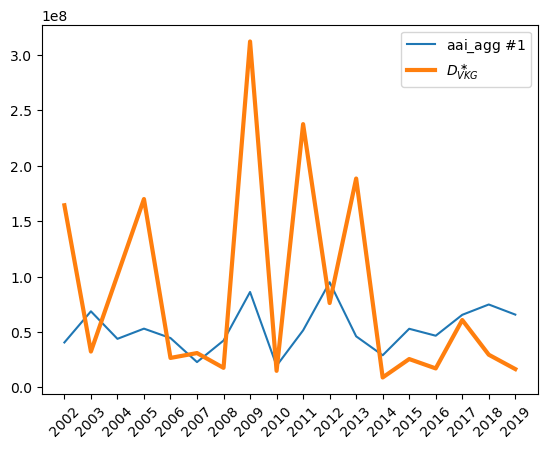

Correlation of the RMSF data for spearman is 0.35397316821465424 with upper limit 0.7122079885637007 and lower limit -0.15053999098721685 with p value of 0.14955138885906258
Correlation of the RMSF data for pearson is 0.2969012638611217 with upper limit 0.6707902118445849 and lower limit -0.19732021641804065 with a p value of 0.23152971091794183
RMSF is 2.6784238000184506


In [22]:
#Class 1
y = np.zeros(150)
y[:] = 0
y[20:30] = 0.000_14
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
plt.figure()
plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
plt.xticks(rotation = 45)
plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))



2021-03-11 13:09:09,104 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:09,108 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:09,111 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 52137724.3778062


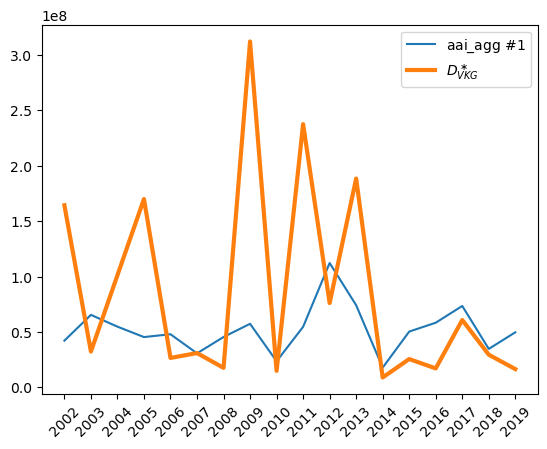

Correlation of the RMSF data for spearman is 0.4633642930856553 with upper limit 0.7755549730092537 and lower limit -0.030934983496360823 with p value of 0.05278586195356671
Correlation of the RMSF data for pearson is 0.2439472559466257 with upper limit 0.6381386508313053 and lower limit -0.2515751302729614 with a p value of 0.3293007791507581
RMSF is 2.5413595654710655


In [23]:
# Class 2
y = np.zeros(150)
y[:] = 0
y[30:40] = 0.000_17
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
plt.figure()
plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
plt.xticks(rotation = 45)
plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))



2021-03-11 13:09:09,551 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:09,553 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:09,556 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 54045181.47042676


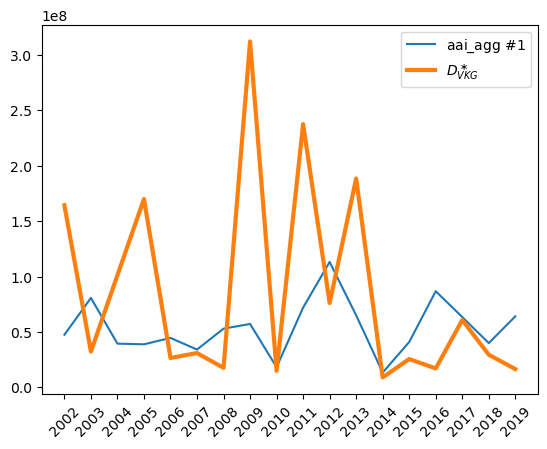

Correlation of the RMSF data for spearman is 0.3023735810113519 with upper limit 0.680276476986631 and lower limit -0.2025291989256477 with p value of 0.22262935502892162
Correlation of the RMSF data for pearson is 0.1676358173142484 with upper limit 0.5884512557566438 and lower limit -0.3246420926001453 with a p value of 0.5061212431896539
RMSF is 2.6796071573243347


In [24]:
# Class 3
y = np.zeros(150)
y[:] = 0
y[40:50] = 0.000_34
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
plt.figure()
plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
plt.xticks(rotation = 45)
plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))



2021-03-11 13:09:09,929 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:09,931 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:09,935 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 56327921.68437539


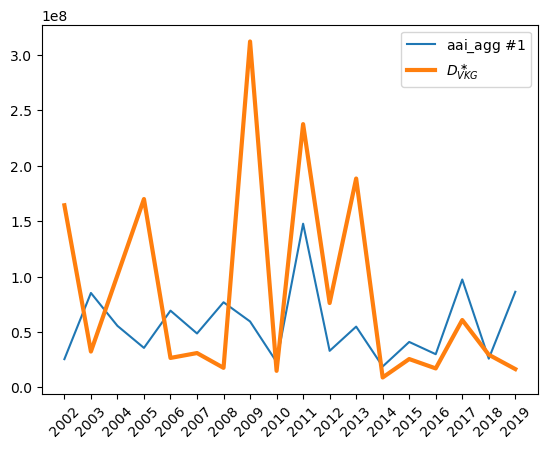

Correlation of the RMSF data for spearman is 0.3126934984520124 with upper limit 0.6867672308473134 and lower limit -0.19232964700299096 with p value of 0.2064536417438368
Correlation of the RMSF data for pearson is 0.269034736370946 with upper limit 0.6537864429648838 and lower limit -0.22625377716714645 with a p value of 0.2803490007008506
RMSF is 2.8626761725722685


In [25]:
# Class 4
y = np.zeros(150)
y[:] = 0
y[50:60] = 0.001_1
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
plt.figure()
plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
plt.xticks(rotation = 45)
plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))



2021-03-11 13:09:10,265 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:10,266 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:10,269 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 85043058.70536844


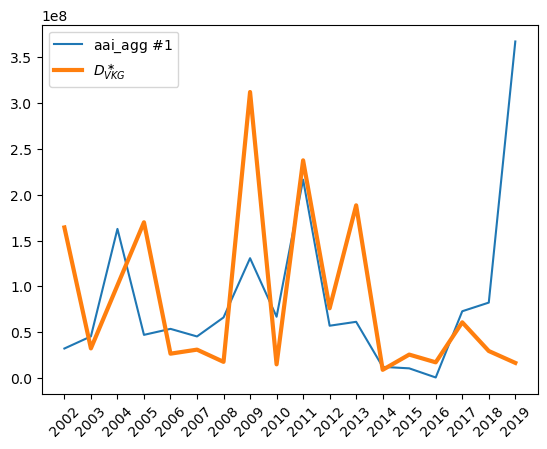

Correlation of the RMSF data for spearman is 0.28792569659442724 with upper limit 0.6711019006843699 and lower limit -0.21665084217714511 with p value of 0.2466148887955486
Correlation of the RMSF data for pearson is 0.20098166704876708 with upper limit 0.6105613493190357 and lower limit -0.2934207588184562 with a p value of 0.42389185685201214
RMSF is 3.930761897311574


In [26]:
# Class 5
y = np.zeros(150)
y[:] = 0
y[60:150] = 0.002_2
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
plt.figure()
plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
plt.xticks(rotation = 45)
plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))



2021-03-11 13:09:10,603 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:10,605 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:10,609 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-11 13:09:10,891 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-11 13:09:10,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-11 13:09:10,894 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-11 13:09:11,129 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

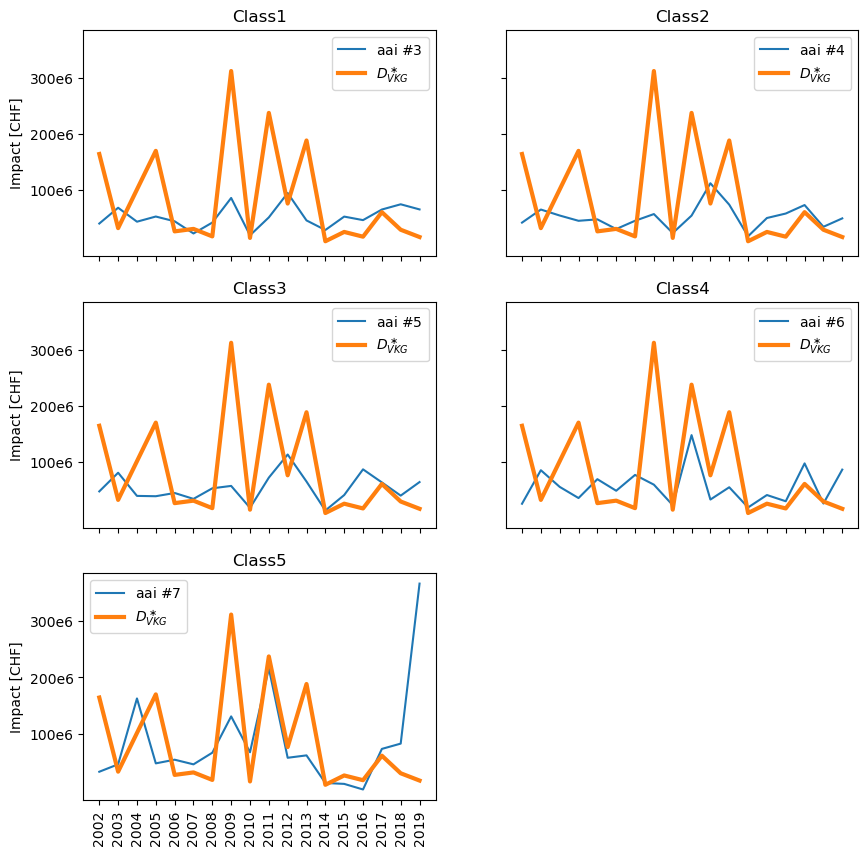

In [27]:
import matplotlib.ticker as ticker
# All Classes
#c1
y = np.zeros(150)
y[:] = 0
y[20:30] = 0.000_14
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c1 = Impact()
imp_RMSF_c1.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c2
y = np.zeros(150)
y[:] = 0
y[30:40] = 0.000_17
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c2 = Impact()
imp_RMSF_c2.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c3
y = np.zeros(150)
y[:] = 0
y[40:50] = 0.000_34
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c3 = Impact()
imp_RMSF_c3.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c4
y = np.zeros(150)
y[:] = 0
y[50:60] = 0.001_1
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c4 = Impact()
imp_RMSF_c4.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c5
y = np.zeros(150)
y[:] = 0
y[60:150] = 0.002_2
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c5 = Impact()
imp_RMSF_c5.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#plot
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

axs[0,0].plot(years, list(imp_RMSF_c1.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0,1].plot(years, list(imp_RMSF_c2.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,0].plot(years, list(imp_RMSF_c3.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,1].plot(years, list(imp_RMSF_c4.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[2,0].plot(years, list(imp_RMSF_c5.calc_impact_year_set(year_range=[2002,2019]).values()))

axs[0,0].plot(dmg_from_vkg, linewidth = 3)
axs[0,1].plot(dmg_from_vkg, linewidth = 3)
axs[1,0].plot(dmg_from_vkg, linewidth = 3)
axs[1,1].plot(dmg_from_vkg, linewidth = 3)
axs[2,0].plot(dmg_from_vkg, linewidth = 3)

axs[2,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)

axs[0,0].legend([r"aai $\# 3$", r"$D_{VKG}^\ast$"])
axs[0,1].legend([r"aai $\# 4$", r"$D_{VKG}^\ast$"])
axs[1,0].legend([r"aai $\# 5$", r"$D_{VKG}^\ast$"])
axs[1,1].legend([r"aai $\# 6$", r"$D_{VKG}^\ast$"])
axs[2,0].legend([r"aai $\# 7$", r"$D_{VKG}^\ast$"])

axs[0,0].title.set_text('Class1')
axs[0,1].title.set_text('Class2')
axs[1,0].title.set_text('Class3')
axs[1,1].title.set_text('Class4')
axs[2,0].title.set_text('Class5')

axs[0,0].set_ylabel("Impact [CHF]")
axs[1,0].set_ylabel("Impact [CHF]")
axs[2,0].set_ylabel("Impact [CHF]")


#y_labels = axs[0,0].get_yticks()
#axs[0,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.0e'))

axs[0,0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0,0].set_yticklabels(labels=["100e6","200e6","300e6"])
#axs[1,0].ticklabel_format(style='sci',scilimits=(0,0),axis='y')

axs[2,1].set_visible(False)
plt.show()




## Duration

In [28]:
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "infr" # ["infr", "agr"]
optimize_type = "dur" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "const" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_meshs.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.01,0.03)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.01_1,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0,0.001,0.000_001)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


y = fct.imp_fun_class(np.arange(150),
                      optimize_results[0],
                      optimize_results[1],
                      optimize_results[2],
                      optimize_results[3],
                      optimize_results[4])
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))
imp_class = Impact()
imp_class.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("aai_agg {:.2e}".format(imp_class.aai_agg))
imp_fun = ifset_hail.get_func()
print(imp_fun["HL"][1].mdd)
#plot
plt.figure()
plt.plot(years, list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend(["class", "vkg"])
plt.xticks(rotation = 45)
plt.show()
print(list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
    

NO dur for infr


AttributeError: 'int' object has no attribute 'values'

In [ ]:
#Base
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "infr" # ["infr", "agr"]
optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "const" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_meshs.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.01,0.03)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.01_1,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0,0.001,0.000_001)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


y = fct.imp_fun_class(np.arange(150),
                      optimize_results[0],
                      optimize_results[1],
                      optimize_results[2],
                      optimize_results[3],
                      optimize_results[4])
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))
imp_class = Impact()
imp_class.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("aai_agg {:.2e}".format(imp_class.aai_agg))
imp_fun = ifset_hail.get_func()
print(imp_fun["HL"][1].mdd)
#plot
plt.figure()
plt.plot(years, list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_vkg, linewidth = 3)
plt.legend(["class", "vkg"])
plt.xticks(rotation = 45)
plt.show()
print(list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
    